In [1]:
from dataset import LamaHDataset
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import torch

/home/kirschstein/miniconda3/envs/floodgnn/lib/python3.11/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
ds = LamaHDataset("/scratch/kirschstein/LamaH-CE", normalized=False)

Loading dataset into memory...


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:16<00:00,  2.61it/s]


In [3]:
def score(windows):
    normed_windows = windows / (ds.mean[:, 0, None, None]) # make discharge comparable across gauges (enforce mean 1)
    
    mean_central_diff = torch.gradient(normed_windows, dim=-1)[0].mean() 
    trapezoid_integral = torch.trapezoid(normed_windows, dim=-1)
    
    score = (mean_central_diff ** 2) * trapezoid_integral
    assert not trapezoid_integral.isinf().any()
    assert not trapezoid_integral.isnan().any()
    return score

In [4]:
score_tensors = []

for i, year_tensor in enumerate(tqdm(ds.year_tensors)):
    windows = year_tensor[:, :, 0].unfold(dimension=-1, size=24, step=1)  
    score_tensors.append(score(windows))

100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  4.31it/s]


In [5]:
extremest_windows = [divmod(score.argmax().item(), score.shape[-1])
                     for score in score_tensors]

In [6]:
extremest_windows

[(339, 5238),
 (233, 8702),
 (255, 5234),
 (268, 646),
 (44, 4555),
 (44, 4588),
 (280, 2079),
 (263, 5975),
 (339, 2690),
 (235, 4162),
 (260, 3651),
 (127, 295),
 (111, 3926),
 (100, 3644),
 (44, 5388),
 (339, 2894),
 (96, 3653),
 (44, 5533)]

In [7]:
all_scores = torch.cat(score_tensors, dim=1)
print(all_scores.min())
print(all_scores.max())
print(all_scores.mean())
print(all_scores.median())

tensor(1.9841e-14)
tensor(2.7549e-05)
tensor(1.1831e-07)
tensor(1.0254e-08)


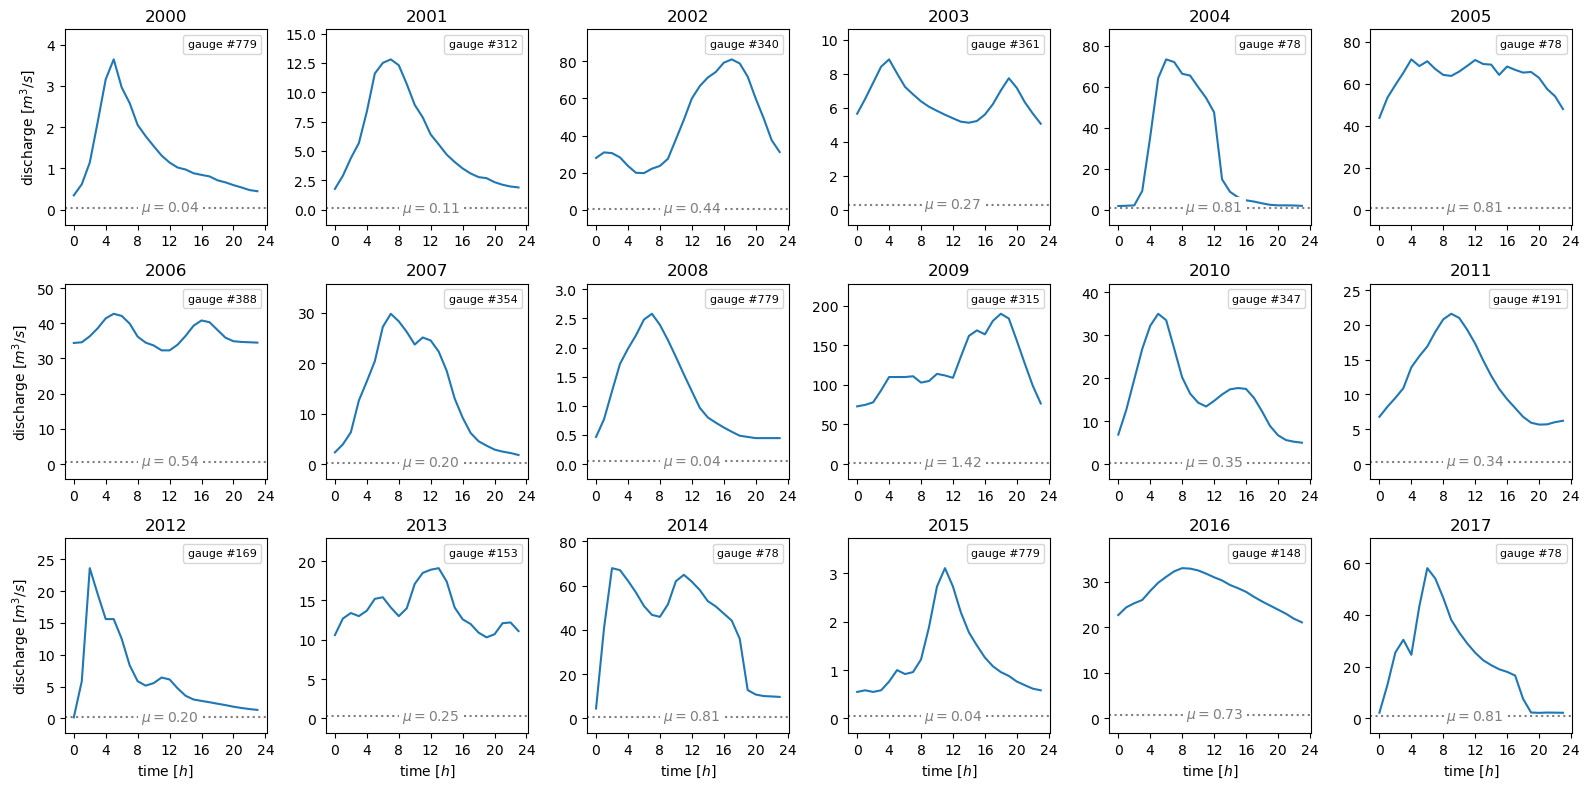

In [117]:
plt.figure(figsize=(16, 8))
for i, (gauge, idx) in enumerate(extremest_windows):
    plt.subplot(3, 6, i + 1)
    plt.title(f"{2000 + i}")
    if i >= 12:
        plt.xlabel("time [$h$]")
    if i % 6 == 0:
        plt.ylabel("discharge [$m^3/s$]")   
    idx += torch.cumsum(torch.tensor(ds.year_sizes), dim=0)[i - 1] if i > 0 else 0
    q = ds[idx].x[gauge, :, 0]
    plt.xticks(list(range(0, 25, 4)))
    plt.ylim(-0.1 * q.max(), 1.2 * q.max())
    plt.plot(q, label=f"gauge #{ds.gauges[gauge]}")
    plt.axhline(y=ds.mean[gauge, 0], color='tab:gray', linestyle = ':') 
    plt.legend(loc="upper right", fontsize=8, handletextpad=0.0, handlelength=0)
    plt.text(12, 1.1 * ds.mean[gauge, 0], f'$\mu = {ds.mean[gauge, 0]:.2f}$', va='center', ha='center', color='tab:gray', bbox=dict(boxstyle='square,pad=0.2', fc='w', ec='none'))
plt.tight_layout()
plt.savefig("relevancy.pdf")